# Ensemble Learning
Group Challenge

***
by: Paul Bédier, Lukasz Pszenny, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [29]:
from importlib import reload
reload(prepData)

<module 'util.preprocess_data' from 'd:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T2_Ensemble Learning\\4_challenge\\Ensemble-Learning-on-AirBnb-dataset\\util\\preprocess_data.py'>

In [30]:
# import own scripts
import util.preprocess_data as prepData

In [44]:
# parse & handle data
import csv
import os
import numpy as np
import pandas as pd
from PIL import Image

# visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Retrieve Data

In [4]:
# Read data
airbnb = pd.read_csv('data/AB_NYC_2019.csv', index_col=0)

In [5]:
airbnb.shape

(48895, 15)

In [6]:
# check type of every column in dataset
airbnb.dtypes

name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
airbnb.iloc[:,3:].describe() # do not compute stats for host_id

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### 3. Handle missing values

<AxesSubplot: xlabel='index'>

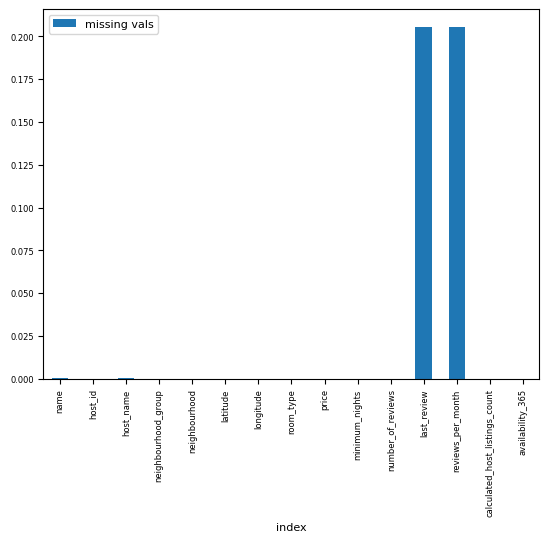

In [8]:
# number of missing values
(airbnb.isna().sum()/len(airbnb)).reset_index(name = "missing vals").plot.bar(x="index", y = "missing vals", rot = 90)

Missing data does not need sophisticated treatment for the exploratory data analysis.

More specifically, "name" and "host_name" columns are likely irrelevant to the overall problem. Maybe we could apply some NLP techniques on the "name" of the listing to identify maybe some keywords that are correlated with higher prices, but we should only do this if later model performance is not sufficient. In contrast, we will drop the column "host_name" right away due to ethical reasons: we do not want our classifier to learn that some names (that sound e.g. more Western European) possibly generate higher listing prices than e.g. traditional names of African Americans or Indigeneous Groups.

The columns "last_review" (date of last review for respective listing) and "reviews_per_month" only have missing values if "number_of_reviews" is 0. "last_review" could be useful to maybe identify some recency metrics, so we will as a first step impute the missing values with the oldest possible date in the dataset. "reviews_per_month" is straightforward: if a listing has 0 total reviews, the number of reviews per month should be 0 as well.

In [9]:
len(airbnb)

48895

In [13]:
airbnb, _ = prepData.impute_missing_vals(airbnb)
airbnb.head(3)

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,last_review_recency,last_review_recency_log_noise
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,262,5.727057
2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,48,3.854585
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2011-03-28,0.00,1,365,3024,7.949607


### 4. Analyse Data

Let us now split our data into three types: categorical, geographical, numerical, others. Each type needs a different approach during analysis.

In [54]:
feature_dict = {
    "cat": ["host_id", "room_type"],
    "geo": ["neighbourhood_group", "neighbourhood", "latitude", "longitude"],
    "num": ["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365", "last_review_recency", "last_review_recency_log_noise"],
    "oth": ["name", "last_review"]
}

#### 4.1 Categorical Features

In [15]:
print(feature_dict["cat"])

['host_id', 'room_type']


4.1.1 Hosts

In [16]:
# who are the top hosts by number of listings?
airbnb.host_id.value_counts().head(10)

219517861    327
107434423    232
30283594     121
137358866    103
16098958      96
12243051      96
61391963      91
22541573      87
200380610     65
7503643       52
Name: host_id, dtype: int64

In [17]:
# how many listings belong to the top1% of all hosts?
topK = 0.01
nbr_hosts = airbnb.host_id.nunique()
print(f"Share of listings that belong to Top {int(topK*100)}% of hosts: {int(round(sum(airbnb.host_id.value_counts().values[:int(topK * nbr_hosts)]) / len(airbnb), 2) * 100)}%")

Share of listings that belong to Top 1% of hosts: 10%


Our Dataset contains 48895 listings.
Our Dataset encompasses 774.9102095999984 Mio. USD yearly revenue.


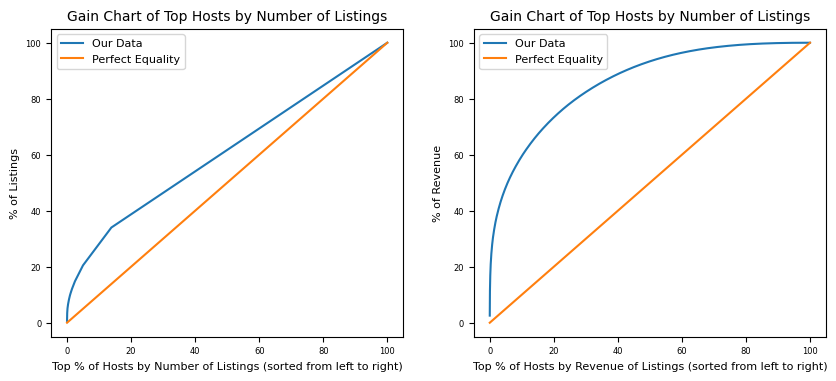

In [18]:
# plot gain chart of hosts by (1) number of listings, (2) yearly revenue of listings
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

# (1) by number of listings

## compute share of listings per host
listings_per_host = np.cumsum(airbnb.host_id.value_counts().values)
x = [(i / len(listings_per_host)) * 100 for i in range(0, len(listings_per_host))]

## plot data
ax[0].plot(x, listings_per_host / len(airbnb) * 100, label = "Our Data")
ax[0].plot(x, x, label = "Perfect Equality")
ax[0].set_title("Gain Chart of Top Hosts by Number of Listings")
ax[0].set_xlabel("Top % of Hosts by Number of Listings (sorted from left to right)")
ax[0].set_ylabel("% of Listings")
ax[0].legend()

print(f"Our Dataset contains {max(listings_per_host)} listings.")

# (2) by yearly revenue of listings
##    - assuming 80% sell out which probably only professional hosts achieve
##    - exluding all listings that have availability_365 == 0 (probably information is not up to date)

## compute revenue per host
yearly_revenue_per_host = np.cumsum(airbnb.loc[airbnb["availability_365"] > 0]
    .assign(yearly_revenue = lambda df_: 0.8 * df_.price * df_.availability_365)
    .groupby(["host_id"])["yearly_revenue"].sum().sort_values(ascending = False)
)
x = [(i / len(yearly_revenue_per_host)) * 100 for i in range(0, len(yearly_revenue_per_host))]

## plot data
ax[1].plot(x, yearly_revenue_per_host/max(yearly_revenue_per_host) * 100, label = "Our Data")
ax[1].plot(x, x, label = "Perfect Equality")
ax[1].set_title("Gain Chart of Top Hosts by Number of Listings")
ax[1].set_xlabel("Top % of Hosts by Revenue of Listings (sorted from left to right)")
ax[1].set_ylabel("% of Revenue")
ax[1].legend()

print(f"Our Dataset encompasses {max(yearly_revenue_per_host) / 1e6} Mio. USD yearly revenue.")

The above plot on the left hand side shows the "inequality" among the hosts: few hosts provide many listings. For example, the top 1% of all hosts (by number of listings) contribute 10% of all listings. This inequality is substantial but much less than what we usually see in income charts. To demonstrate this, we plotted on the right hand side the share of revenue where revenue = price $\times$ availability_365 * 0.8 (multiplied with 0.8 as we assume only 80% sell out). Also, we removed any listings where the availability is equal to 0 (probably information for this listing not up to date) to avoid skewing the chart too much in favor of the highest earning donors. In this chart, the inequality is quite extreme and follows the well-known pareto rule: the top 20% of donors (by yearly revenue) generate 80% of total revenue in the airbnb market in New York City.

As the pareto rule is applicable, we can directly deduce that the revenue is distributed across the hosts in a power law. But it is even the case for the number of listings! To demonstrate this, let us plot a histogram of the number of listings per host. If the plot shows a linear relation in the loglog scale, it means that the underlying distribution follows a power law. (Hint1: based on what we already know, it definitely should) (Hint2: and it does!)

Text(0.5282090928819461, 0.5, 'Number of Hosts')

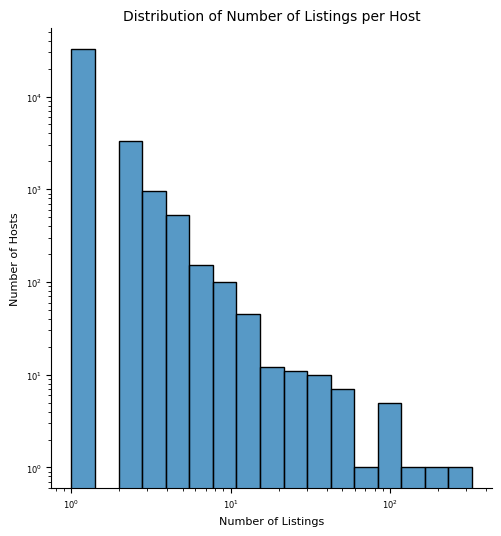

In [19]:
# plot distribution of number of listings per host
sns.displot(airbnb.host_id.value_counts().values, fill = True, log_scale = (True, True), common_norm = True)

# plot options
plt.title("Distribution of Number of Listings per Host")
plt.xlabel("Number of Listings")
plt.ylabel("Number of Hosts")

4.1.2 Room Type

Our Dataset contains the following room types: ['Private room' 'Entire home/apt' 'Shared room']


(0.0, 600.0)

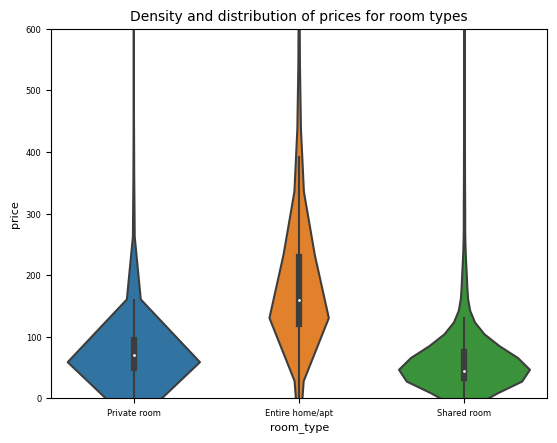

In [20]:
# let us look at the average price per room type (violin chart)
# we have to truncate extreme values as violin chart on logarithmic scale can be easily misleading (also some prices = 0, which makes use of logarithm even more challenging)
print(f"Our Dataset contains the following room types: {airbnb.room_type.unique()}")
sns.violinplot(data = airbnb, x='room_type', y='price', log_scale = (True, True))
plt.title('Density and distribution of prices for room types')
plt.ylim((0, 600))

The results are as expected:
- shared rooms are the least expensive and rarely go beyond 100 USD per night
- private rooms are a bit more expensive but most values concentrate around the median as well
- entire home/apt are much more expensive (median around 160 USD per night) and values are not concentrated around the median --> these locations can be very expensive very fast

#### 4.2 Geographical Features

In [21]:
print(feature_dict["geo"])

['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude']


It is clear that a good location will be a clear driver for the price of the listing: Airbnb travellers love good locations with good access to e.g. the subway and short commutes to popular sights.

In consequence, the location of the listing should be an important predictor for our model. However, just using latitude and longitude might be too hard: we will be using tree-based methods, where often (e.g. in RandomForests) it is not clear which feature will be used for the split (but latitude and longitude heavily depend on each other).

Of course, we will still include latitude and longitude, but maybe it is worth to explore two ideas:
1. computing distances to region center (to have some measure of centrality)
2. encoding the neighbourhood features using the target variable (need to regularize and potentially add noise to counter overfitting)

Regarding the first idea, we would want to compute some sort of distance measurement to the neighbourhood center. The nice catch: distances are 1D representations, so our trees could easily use that for the splits (instead of latitude and longitude, where randomness of some methods can impose difficulties).

Regarding the second idea, this is a "fancy" version of target encoding. Why does this make sense? We are given the neighbourhood group and the actual neighbourhood of the data. These features are of increasing cardinality (level 1 [neighbourhood_group] has 5 unique values, level 2 [neighbourhood] 221). Because of this, techniques like one-hot-encoding would lead to extremely sparse matrices. Trees might still work with this kind of data, but computationally speaking this is very inefficient (also, if for each split we only consider a subset of our features as candidates, we might end up biasing our trees to only perform splits using the one-hot encoded data as they would make up a huge percentage of our overall features). But even if we directly used target encoding, the increasing cardinality might create problems. For example, maybe a specific level 2 region has only one listing. Calculating this entries mean and standard deviation might not be representative of the population in this subregion and could introduce both high bias and high variance.

While searching online, we found a potential method to deal with this problem: *Empirical Bayes Target Encoding*, which is described in detail in the paper "A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems" by Daniele Micci-Barreca (weblink: https://dl.acm.org/doi/10.1145/507533.507538). A good understanding of the paper can be deduced from this web article (written by the same author): https://towardsdatascience.com/extending-target-encoding-443aa9414cae.

In consequence, we will use Empirical Bayes Target Encoding to meaningfully encode the neighbourhood features. In contrast, the actual geographical features (latitude + longitude) will remain unchanged.

One important (and likely wrong assumption) of our estimation of $\lambda_{L_{i}}$ is that we assume the probability distribution to be Gaussian (of the prices within the chosen subregion as well as of the posterior).

For our case, the mathematical formulation for the target encoding of the mean price looks like this (we will also do the same for the standard deviation):

$$\text{Empirical Bayes Target Encoding }(L_{0}, L_{1}, L_{2}) = \lambda_{L_{2}} \times \frac{\sum_{i \in L_{2}}Y_{i}}{n_{L_{2}}} + (1 - \lambda_{L_{2}}) \times \text{Empirical Bayes Target Encoding }(L_{0}, L_{1})$$

$$\text{Empirical Bayes Target Encoding }(L_{0}, L_{1}) = \lambda_{L_{1}} \times \frac{\sum_{i \in L_{1}}Y_{i}}{n_{L_{1}}} + (1 - \lambda_{L_{1}}) \times \frac{\sum_{k \in L_{0}}Y_{k}}{n_{L_{0}}} $$

$$\text{Blending Factor }\lambda_{L_{i}} = \frac{n_{L_{i}} \times \text{Var}_{L_{i-1}}}{\text{Var}_{L_{i}} + n_{L_{i}} \times \text{Var}_{L_{i-1}}}$$

where
- $L_{0}$ relates to all the data, $L_{1}$ relates to the data of the current neighbourhood_group, $L_{2}$ to the data of the current neighbourhood 
- $n_{L_{i}}$ is the number of datapoints included in the current level

4.2.1 Neighbourhood features

Our Dataset contains the following neighbourhood groups: ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']


(0.0, 600.0)

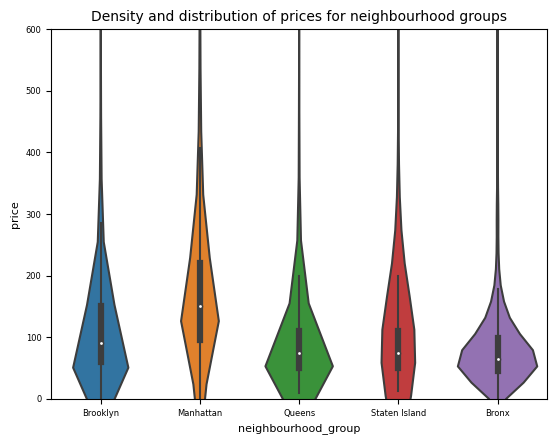

In [22]:
# let us look at the average price per neighbourhood group (violin chart)
# we have to limit y-axis as violin chart on logarithmic scale can be easily misleading (also some prices = 0, which makes use of logarithm even more challenging)
print(f"Our Dataset contains the following neighbourhood groups: {airbnb.neighbourhood_group.unique()}")
sns.violinplot(data = airbnb, x='neighbourhood_group', y='price', log_scale = (True, True))
plt.title('Density and distribution of prices for neighbourhood groups')
plt.ylim((0, 600))

The results are as expected:
- Manhattan has the highest price range and highest median price (150 USD per night)
- Brooklyn shows also high price range but only slightly above median price of other regions (90 USD per night)
- Queens, Staten Island and Bronx show very similar median prices of around 80 USD per night
- Bronx is the cheapest overall

When considering the actual neighborhoods, there are too many to plot them (221, see cell below).

In [31]:
print(f"Number of unique neighbourhoods in dataset: {airbnb.neighbourhood.nunique()}")

Number of unique neighbourhoods in dataset: 221


However, we can look at the distribution of the number of listings per neighbourhood!

Text(6.069444444444445, 0.5, 'Number of Neighbourhoods')

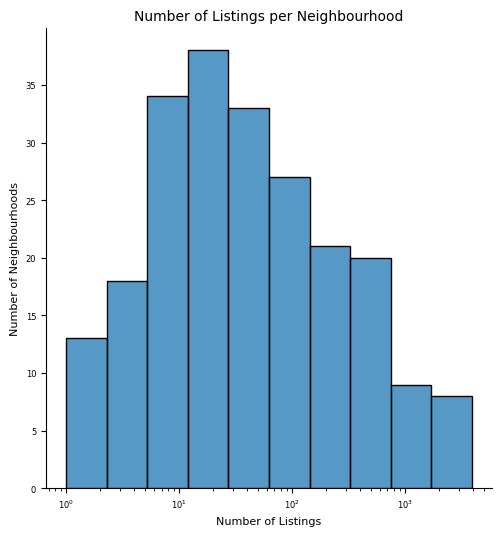

In [32]:
# plot distribution of number of listings per neighbourhood
sns.displot(airbnb.neighbourhood.value_counts().values, fill = True, log_scale = (True, False), common_norm = True)

# plot options
plt.title("Number of Listings per Neighbourhood")
plt.xlabel("Number of Listings")
plt.ylabel("Number of Neighbourhoods")

Some neighbourhoods have only very few listings (e.g. 13 neighbourhoods have less than 10 listings) while others have a lot (e.g. 20 neighbourhoods have more than 1,000 listings)! In consequence, the above proposed hierarchical target encoding could be a very good idea!

Why? For neighbourhoods with few listings we will still be able to generate a meaningful target encoding that is not overfitting (because for these neighbourhoods, we will encode them using mostly the information from the previous layer, as in the respective neighbourhood_group).

Let us now compute the two features: (1) Euclidian Distance of observation to Neighbourhood (Group) Center, and (2) Empirical Bayes Target Encoding of the Neighbourhood features.

In [36]:
airbnb, _ = prepData.encode_geo_fts(airbnb)
airbnb.head(3)

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,last_review_recency,last_review_recency_log_noise,l2_mean,l2_sd,distance_l1,distance_l2
id,,,,,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,262,5.727057,92.976156,74.170211,0.043108,0.006638
2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,48,3.854585,283.526038,255.415378,0.014659,0.008048
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,2011-03-28,0.00,1,365,3024,7.949607,120.216553,156.571116,0.054791,0.009293


In [55]:
# append new numerical features to feature dict
feature_dict["num"].extend(["l2_mean", "l2_sd", "distance_l1", "distance_l2"])

4.2.2 Geolocation features

We will keep latitude and longitude as they are!

Only to verify our preprocessing / understand the data better, we will now plot capped prices as well as the Euclidian distances and the target encoded level 2 below to better understand our dataset.

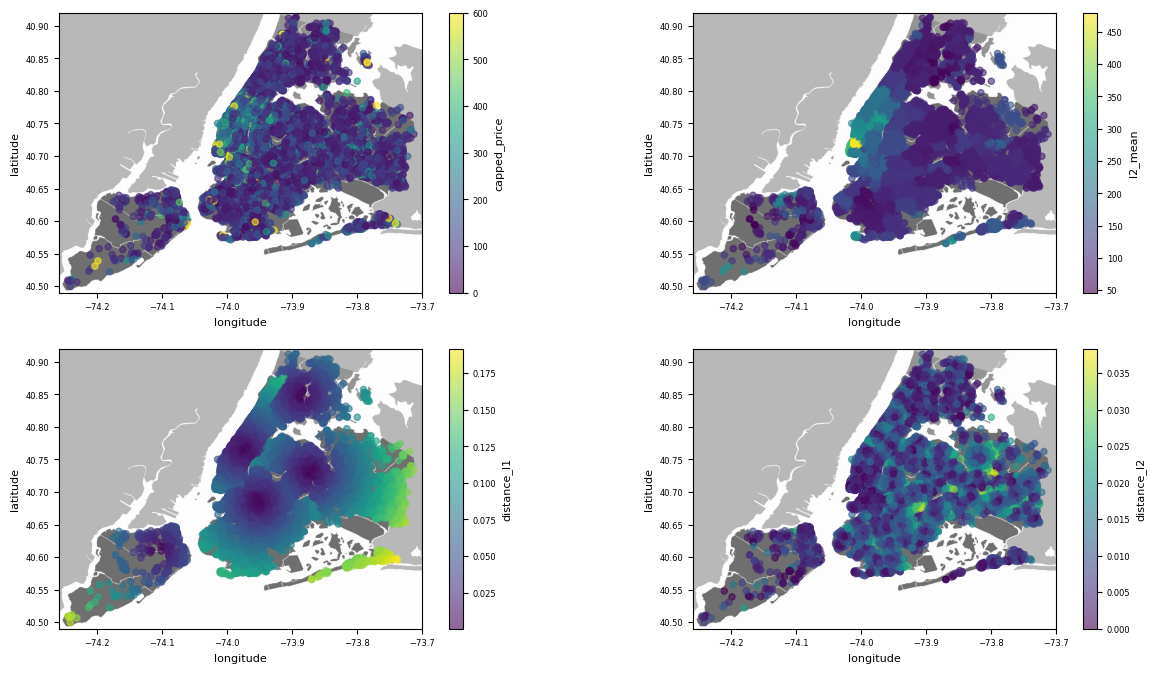

In [51]:
# which features we want to overlay on NYC map
plot_fts = ["capped_price", "l2_mean", "distance_l1", "distance_l2"]

# remove outliers (they will distort our price plot otherwise)
cap = 600
airbnb_no_extreme_prices = airbnb.assign(capped_price = lambda df_: df_.price.where(df_.price < cap, cap))

# create canvas where we will overlay our features
fig, axs = plt.subplots(2, 2, figsize = (15, 8))

for ax, ft in zip(axs.flatten(), plot_fts):

    # (1) map of NYC
    nyc_map = Image.open("data/New_York_City_.png")
    ax.imshow(nyc_map, zorder = 0, extent = [-74.258, -73.7, 40.49, 40.92]) # scale image according to latitude and longitude min & max
    
    # (2) scatterplot of capped prices on top
    airbnb_no_extreme_prices.plot(kind = "scatter", x = "longitude", y = "latitude", c = ft, colormap = "viridis",
                                  ax = ax, colorbar = True, alpha = 0.6, zorder = 5)

The results make a lot of sense:
- first plot (capped_price) shows what we already know --> Manhattan is most expensive, etc
- second plot (l2_mean) should look like a smoothened version of the first plot (thanks to hierarchical target encoding), and it does!
- third plot (distance_l1) shows the distance of each observation to the center of its neighbourhood group (and we would expect to see five big circles)
- fourth plot (distance_l2) shows the distance of each observation to the center of its neighbourhood (and we would expect to see smaller circles around each neighbourhood)

#### 4.3 Numerical Features

In [56]:
print(feature_dict["num"])

['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'last_review_recency', 'last_review_recency_log_noise', 'l2_mean', 'l2_sd', 'distance_l1', 'distance_l2']


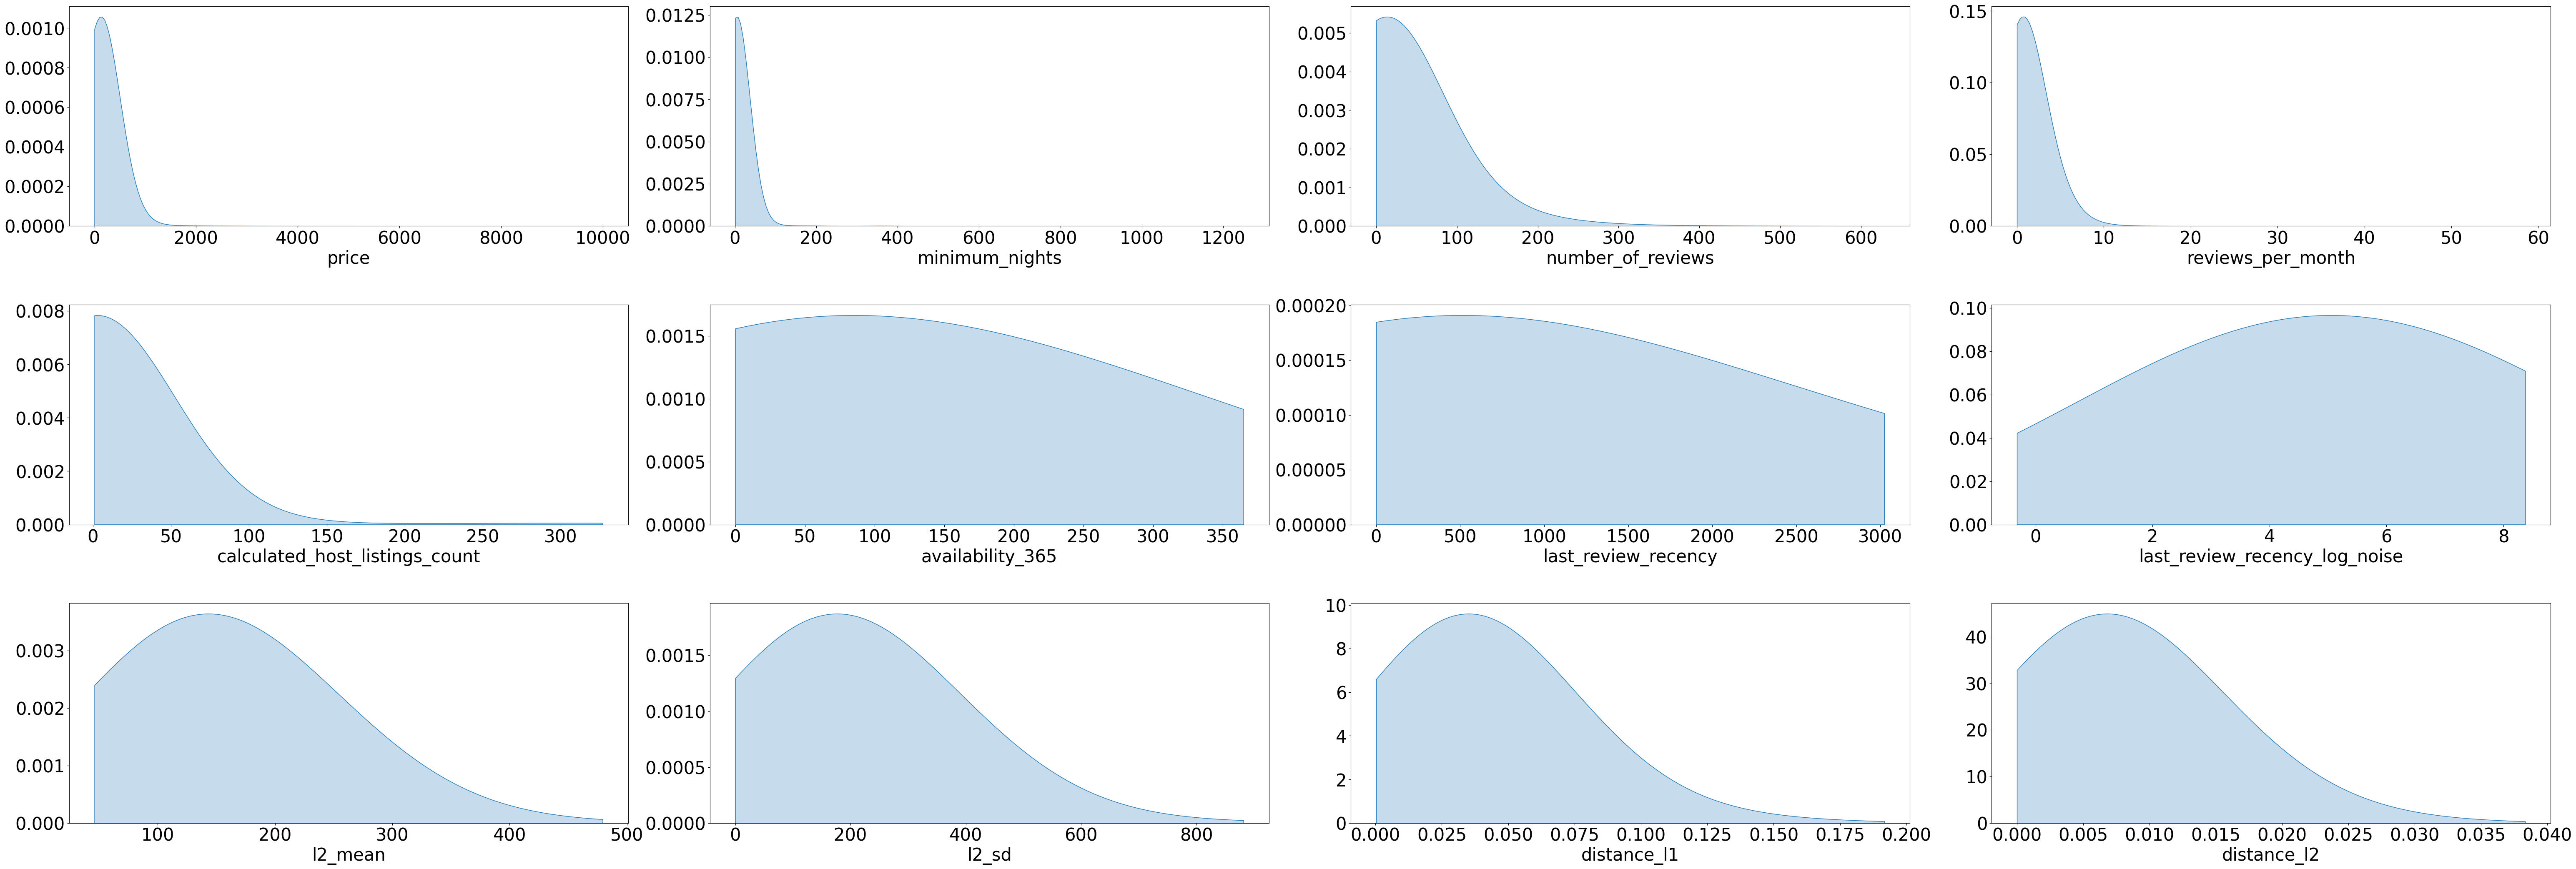

In [57]:
# visualize distributions of our numerical features

# (1) subset dataframe
num_fts = feature_dict['num']
num_fts_df = airbnb.loc[:, num_fts]

# (2) initialise subplots
fig, axs = plt.subplots(3, 4, figsize = (60, 20))
fig.tight_layout(w_pad = 20, h_pad = 20)

# (3) create plots
for i, ax in enumerate(axs.flat):
    if i < len(num_fts):
        sns.kdeplot(num_fts_df.iloc[:, i], bw_method = 1.5, ax = ax, cut = 0, fill = True)
        ax.tick_params(axis = 'both', which = 'major', labelsize = 30)
        ax.set_xlabel(num_fts[i], fontsize = 30)
        ax.set(ylabel = None)

Some of our features are very heavy tailed (e.g. number_of_reviews). Many machine learning techniques would require us to transform the data to allow for better convergence. This is not the case however for tree based methods as they are invariant to the scaling of inputs! Thus, we will not apply any transformations to our numerical data.